In [ ]:
# this gives access to our project folder in google drive.
import os
os.chdir("/content/drive/MyDrive/programs/Datasets/toxic comment classification")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# importing dependecies
import os
import numpy as np  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re           
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv('../data/train.csv')
print("Shape of data : ", dataset.shape)
dataset.head(3)

Shape of data :  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [ ]:
stop_words = set(stopwords.words('english'))
# function to preprocess and remove stopwords
def preprocess(text):
  no_stops = []
  sent = text.lower()
  sent = re.sub(r"[^a-zA-Z]"," ",sent)    # removes all characters except alphabets
  sent = re.sub(r'\s+', ' ', sent)       # removes extra white spaces
  #sent = str(text)
  for w in sent.split():
    if not w in stop_words:
      no_stops.append(w)
  long_words = [word for word in no_stops if len(word)>3]
  return (" ".join(long_words))

In [ ]:
data = dataset.copy()
data['cleaned_comments'] = data['comment_text'].apply(lambda x: preprocess(str(x)))

In [ ]:
# loading the glove model
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    word_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    print ("Done."),len(word_embeddings),(" words loaded!")
    return word_embeddings

In [ ]:
# load the glove model . 
word_embedding=loadGloveModel("../glove vector/glove.6B.100d.txt")

Loading Glove Model
Done.


In [ ]:
# separate and set independent and target/dependent features.Then split data into train set and test set
X = data['cleaned_comments']
Y = data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)
train_pad = pad_sequences(train_seq)
test_pad = pad_sequences(test_seq, maxlen=train_pad.shape[1])
word_index = tokenizer.word_index

print('The number of unique tokens are {}'.format(len(word_index)))
print("Now train and test tensor shape is : ", train_pad.shape,test_pad.shape)
print('target train and test tesor shape is: ', y_train.shape,y_test.shape)

The number of unique tokens are 141661
Now train and test tensor shape is :  (127656, 1000) (31915, 1000)
target train and test tesor shape is:  (127656, 6) (31915, 6)


In [ ]:
vocab_size = len(word_index)+1
sequence_len = train_pad.shape[1]
embedded_dim = 100
# creating embedding matrix
embedding_matrix = np.zeros((vocab_size,embedded_dim))
for word, i in word_index.items():
  embedding_vector = word_embedding.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(141662, 100)

In [ ]:
# Build and train model
def train_model():
  model = Sequential()
  model.add(Embedding(vocab_size, embedded_dim, weights=[embedding_matrix], input_length=sequence_len))
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  #model.add(Dense(24, activation='relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(6 ,activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = train_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         14166200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 14,284,222
Trainable params: 14,284,222
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_pad, y_train, batch_size=150, epochs=5, validation_data=(test_pad, y_test))

Epoch 1/5
852/852 [==============================] - 237s 240ms/step - loss: 0.1106 - accuracy: 0.7926 - val_loss: 0.0582 - val_accuracy: 0.9941
Epoch 2/5
852/852 [==============================] - 203s 239ms/step - loss: 0.0551 - accuracy: 0.9677 - val_loss: 0.0543 - val_accuracy: 0.9938
Epoch 3/5
852/852 [==============================] - 202s 238ms/step - loss: 0.0504 - accuracy: 0.9766 - val_loss: 0.0548 - val_accuracy: 0.9928
Epoch 4/5
852/852 [==============================] - 202s 237ms/step - loss: 0.0490 - accuracy: 0.9684 - val_loss: 0.0546 - val_accuracy: 0.9934
Epoch 5/5
852/852 [==============================] - 201s 236ms/step - loss: 0.0461 - accuracy: 0.9716 - val_loss: 0.0566 - val_accuracy: 0.9935


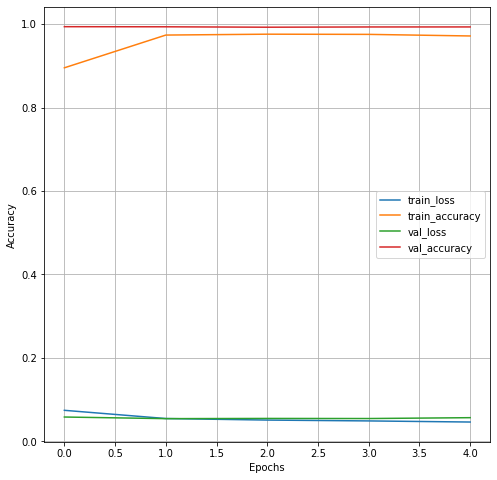

In [ ]:
#save model
model.save('../saved_models/lstm_model.h5')

history_df = pd.DataFrame(model.history.history).rename(columns={"loss":"train_loss", "accuracy":"train_accuracy"})
history_df.plot(figsize=(8,8))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('../plots/AccuracyVsLoss.png')
plt.show()

In [ ]:
# Evaluating 
score = model.evaluate(test_pad, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 21s 21ms/step - loss: 0.0566 - accuracy: 0.9935
Test Score: 0.056615203619003296
Test Accuracy: 0.9934827089309692


pretty decent!

In [ ]:
y_pred = model.predict_classes(test_pad)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
#multilabel_confusion_matrix(y_test,y_pred)

### Test  
predict the toxic labels/categires for given string

In [ ]:
def Execute(text):
  test_str = preprocess(text)
  t_seq = tokenizer.texts_to_sequences([test_str])
  t_pad = pad_sequences(t_seq, maxlen=train_pad.shape[1])
  predicted = model.predict(t_pad)
  result = predicted[0]
  categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
  predicted_categories = []
  #probability = []
  for category, prob_value in zip(categories,result):
    if prob_value>0.80:
      predicted_categories.append(category)
      #probability.append(value)
  print('The given comment is :', predicted_categories)    
  #print(predicted_categories)
  #print(zip(predicted_categories,probability))

In [ ]:
#test_string = "I don't give the fuck those goddamn morons says."
test_string ="You little piece of shit do you really want me to smack on your fucking face goddamn moron"
predict_categories = Execute(test_string) 

The given comment is : ['toxic', 'obscene', 'insult']


In [ ]:
test_string = str(input('Input the test string :'))
predict_categories = Execute(test_string)

Input the test string :fuck you assholes
The given comment is : ['toxic', 'obscene']
